# RNN 성능향상

* 순환 드롭아웃 : 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃
* 순환 층 스태킹 : 네트워크의 표현 능력을 증가(계산 비용증가).
* 양방향 순환 층 : 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


In [4]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 14s 90ms/step - loss: 0.5046 - acc: 0.7564 - val_loss: 0.4031 - val_acc: 0.8418
Epoch 2/10
157/157 [==============================] - 14s 87ms/step - loss: 0.2975 - acc: 0.8845 - val_loss: 0.3379 - val_acc: 0.8758
Epoch 3/10
157/157 [==============================] - 14s 87ms/step - loss: 0.2426 - acc: 0.9094 - val_loss: 0.2893 - val_acc: 0.8804
Epoch 4/10
157/157 [==============================] - 14s 87ms/step - loss: 0.2001 - acc: 0.9271 - val_loss: 0.2847 - val_acc: 0.8888
Epoch 5/10
157/157 [==============================] - 14s 88ms/step - loss: 0.1768 - acc: 0.9359 - val_loss: 0.3018 - val_acc: 0.8904
Epoch 6/10
157/157 [==============================] - 14s 87ms/step - loss: 0.1575 - acc: 0.9441 - val_loss: 0.3112 - val_acc: 0.8762
Epoch 7/10
157/157 [==============================] - 14s 87ms/step - loss: 0.1423 - acc: 0.9498 - val_loss: 0.3611 - val_acc: 0.8796
Epoch 8/10
157/157 [==============================] - 14s 87ms

## 과대적합 감소를 위해 순환 드롭아웃 사용하기

- dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값
- recurrent_dropout은 순환 상태의 드롭아웃 비율을 정함

In [7]:
# from keras import backend as K
# K.clear_session()

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, dropout=0.5,recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 409s 3s/step - loss: 0.5389 - acc: 0.7372 - val_loss: 0.4787 - val_acc: 0.7904
Epoch 2/10
157/157 [==============================] - 403s 3s/step - loss: 0.3420 - acc: 0.8643 - val_loss: 0.2869 - val_acc: 0.8810
Epoch 3/10
157/157 [==============================] - 406s 3s/step - loss: 0.2842 - acc: 0.8885 - val_loss: 0.3221 - val_acc: 0.8646
Epoch 4/10
157/157 [==============================] - 412s 3s/step - loss: 0.2435 - acc: 0.9075 - val_loss: 0.7214 - val_acc: 0.8120
Epoch 5/10
157/157 [==============================] - 415s 3s/step - loss: 0.2250 - acc: 0.9158 - val_loss: 0.3237 - val_acc: 0.8814
Epoch 6/10
157/157 [==============================] - 416s 3s/step - loss: 0.1976 - acc: 0.9269 - val_loss: 0.5430 - val_acc: 0.8546
Epoch 7/10
157/157 [==============================] - 418s 3s/step - loss: 0.1897 - acc: 0.9294 - val_loss: 0.3215 - val_acc: 0.8844
Epoch 8/10
157/157 [==============================] - 422s 3s/step - 

## 스태킹 순환 층

순환 층을 차례대로 쌓으려면 모든 중간 층은 전체 시퀀스(3D 텐서)를 출력해야 함 `return_sequences=True`로 지정

In [8]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(layers.GRU(32, dropout=0.1,recurrent_dropout=0.5,return_sequences=True))
model.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 727s 5s/step - loss: 0.5248 - acc: 0.7242 - val_loss: 0.5864 - val_acc: 0.7186
Epoch 2/10
157/157 [==============================] - 722s 5s/step - loss: 0.3460 - acc: 0.8540 - val_loss: 0.3998 - val_acc: 0.8138
Epoch 3/10
157/157 [==============================] - 726s 5s/step - loss: 0.2846 - acc: 0.8846 - val_loss: 0.3920 - val_acc: 0.8302
Epoch 4/10
157/157 [==============================] - 737s 5s/step - loss: 0.2537 - acc: 0.8995 - val_loss: 0.3246 - val_acc: 0.8646
Epoch 5/10
157/157 [==============================] - 733s 5s/step - loss: 0.2202 - acc: 0.9159 - val_loss: 0.3632 - val_acc: 0.8504
Epoch 6/10
157/157 [==============================] - 732s 5s/step - loss: 0.1990 - acc: 0.9254 - val_loss: 0.4502 - val_acc: 0.8304
Epoch 7/10
157/157 [==============================] - 729s 5s/step - loss: 0.1874 - acc: 0.9306 - val_loss: 0.3460 - val_acc: 0.8690
Epoch 8/10
157/157 [==============================] - 727s 5s/step - 

## Loss

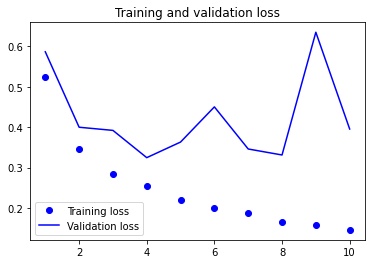

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상

## 양방향 RNN

- 입력 시퀀스를 뒤집음(순서를 역으로)
- LSTM 적용

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 18s 116ms/step - loss: 0.4940 - acc: 0.7599 - val_loss: 0.4607 - val_acc: 0.8264
Epoch 2/10
157/157 [==============================] - 17s 108ms/step - loss: 0.3110 - acc: 0.8816 - val_loss: 0.4438 - val_acc: 0.8222
Epoch 3/10
157/157 [==============================] - 17s 108ms/step - loss: 0.2512 - acc: 0.9086 - val_loss: 0.3371 - val_acc: 0.8562
Epoch 4/10
157/157 [==============================] - 17s 108ms/step - loss: 0.2143 - acc: 0.9237 - val_loss: 0.3511 - val_acc: 0.8572
Epoch 5/10
157/157 [==============================] - 17s 108ms/step - loss: 0.1852 - acc: 0.9323 - val_loss: 0.3397 - val_acc: 0.8688
Epoch 6/10
157/157 [==============================] - 17s 108ms/step - loss: 0.1668 - acc: 0.9424 - val_loss: 0.3729 - val_acc: 0.8748
Epoch 7/10
157/157 [==============================] - 17s 108ms/step - loss: 0.1430 - acc: 0.9492 - val_loss: 0.4958 - val_ac

시간 순서로 훈련한 LSTM과 거의 동일한 성능 => 양방향 RNN은 성능을 향상시킴

In [3]:
from keras import backend as K
K.clear_session()

In [4]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 30s 190ms/step - loss: 0.5477 - acc: 0.7167 - val_loss: 0.3697 - val_acc: 0.8516
Epoch 2/10
157/157 [==============================] - 29s 185ms/step - loss: 0.3243 - acc: 0.8786 - val_loss: 0.3275 - val_acc: 0.8656
Epoch 3/10
157/157 [==============================] - 29s 183ms/step - loss: 0.2630 - acc: 0.9023 - val_loss: 0.3535 - val_acc: 0.8608
Epoch 4/10
157/157 [==============================] - 29s 182ms/step - loss: 0.2264 - acc: 0.9186 - val_loss: 0.4250 - val_acc: 0.8700
Epoch 5/10
157/157 [==============================] - 29s 182ms/step - loss: 0.2016 - acc: 0.9267 - val_loss: 0.4480 - val_acc: 0.8708
Epoch 6/10
157/157 [==============================] - 29s 183ms/step - loss: 0.1812 - acc: 0.9363 - val_loss: 0.3616 - val_acc: 0.8820
Epoch 7/10
157/157 [==============================] - 29s 185ms/step - loss: 0.1634 - acc: 0.9438 - val_loss: 0.3570 - val_acc: 0.8578
Epoch 8/10
157/157 [==============================] - 2

- 여기서 얻은 검증 정확도는 88% 정도로 앞서 사용했던 일반 LSTM보다 조금 더 성능이 높음.
- 이 모델은 조금 더 일찍 과대적합.
- 양방향 순환 층이 단방향 LSTM보다 모델 파라미터가 두 배 많기 때문
- 규제를 조금 추가한다면 양항뱡 순환 층을 사용하는 것이 이 작업에 더 적합



## 과대적합 감소를 위해 순환 드롭아웃 사용하기

- dropout은 층의 입력에 대한 드롭아웃 비율을 정하는 부동 소수 값
- recurrent_dropout은 순환 상태의 드롭아웃 비율을 정함

In [15]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


In [ ]:
from keras import backend as K
K.clear_session()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.2,recurrent_dropout=0.2)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
  3/157 [..............................] - ETA: 8:55 - loss: 0.6924 - acc: 0.5156

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()